# ACE Datathon 2019 Final Code

The ACE Datathon is a competition at ETH Zurich organized by the Analytics Club at ETH (ACE). The competition lasted 24 hours and it had to be solved a Machine Learning Challenge in the field of news popularity prediction. With my team (TeamInt) we finished second in the first part of the competition (https://www.kaggle.com/c/acedatathon19-crypto/leaderboard). With the following pitch we secured the first place.

**Competition Details:**

Cryptocurrencies have been a popular trend in finance and technology in the past few years. Daily, a large amount of news articles about cryptocurrencies are published, making it difficult for individuals and investors to make informative decisions. In this challenge, we would like to use social media to predict the popularity of cryptocurrencies related news articles.

In particular, we track data from Twitter and we quantify the popularity of news articles as the number of mentions that an article get on Twitter, i.e. the **number of tweets** that contain the article's url.

Given the cumulative number of mentions on Twitter in the first hour since an article's publication, and the article's text features (title and sentences), the goal of this challenge is to predict the number of mentions of the article after 24 hours.

Link to the competition: https://www.kaggle.com/c/acedatathon19-crypto/overview

If you have any question regarding the competition or the code, please feel free to contact me at the following email address philniggli@gmail.com

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import textstat
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 40)


## Import Data

In [2]:
x = pd.read_csv("train.csv")
y = x.label
x_test = pd.read_csv("test.csv")

## Feature Preparation

**Readability**

Readability based on the Coleman Liau Index

Source: https://pypi.org/project/textstat/

In [3]:
def readability(text):
    index = textstat.coleman_liau_index(text)
    return(index)

readability(x.sentences[1])
x['Readability'] = x['sentences'].apply(lambda x: readability(x))
x_test['Readability'] = x_test['sentences'].apply(lambda x: readability(x))

**Features related to the URL**

In [4]:
def get_source(s):
    foundwww = s.find("//www")
    founddoubleslash = s.find("//")
    if foundwww> 0:
        substring = s[foundwww+6:]
        finalstring = substring[:7]
        return finalstring

    elif founddoubleslash > 0 :
        substring = s[founddoubleslash + 2:]
        finalstring = substring[:7]
        return finalstring
    else:
        return "unknown"

x["source"] = x["url"].apply(lambda s: get_source(s))
x_test["source"] = x_test["url"].apply(lambda s: get_source(s))

sources = x.source.unique()
source_mean = {}
source_std = {}
for k in sources:
    counting = x["label"].loc[(x.source.isin([k]))]
    source_mean[k] = np.mean(counting)
    source_std[k] = np.std(counting)

x["expectedlabel"] = x["source"].apply(lambda s: source_mean[s])
x["expectedlabel_std"] = x["source"].apply(lambda s: source_std[s])
x_test["expectedlabel"] = x_test["source"].apply(lambda s: source_mean[s])
x_test["expectedlabel_std"] = x_test["source"].apply(lambda s: source_std[s])

**Assembling further features**

In [5]:
x["title_number_characters"] = x["news_title"].apply(lambda x: len(str(x)))
x["title_number_words"] = x["news_title"].apply(lambda x: len(str(x).split()))
x["source"] = x["url"].apply(lambda s: get_source(s))
x["expectedlabel"] = x["source"].apply(lambda s: source_mean[s])
x["square_x1"] = x["tweet_amount_1.0h"].apply(lambda s: np.square(s))
x["num_sentences"] = x["sentences"].apply(lambda x: len(str(x)))

x_test["title_number_characters"] = x_test["news_title"].apply(lambda x: len(str(x)))
x_test["title_number_words"] = x_test["news_title"].apply(lambda x: len(str(x).split()))
x_test["source"] = x_test["url"].apply(lambda s: get_source(s))
x_test["expectedlabel"] = x_test["source"].apply(lambda s: source_mean[s])
x_test["square_x1"] = x_test["tweet_amount_1.0h"].apply(lambda s: np.square(s))
x_test["num_sentences"] = x_test["sentences"].apply(lambda x: len(str(x)))

**Final Feature List**

In [6]:
pred_features=['expectedlabel_std','Readability','square_x1','tweet_amount_0.25h', 'tweet_amount_0.5h','tweet_amount_1.0h']

## Machine Learning and Evaluation

**Define and Evaluate models** given pred_features

In [7]:
model_names = ['linreg', 'rf']
LinReg = LinearRegression()
Rf = RandomForestRegressor(n_estimators=100, random_state=1,max_depth=5)

models = {'linreg': LinReg, 'rf': Rf}
cv_results = {'linreg': [], 'rf': []}
predictions = {'linreg': [], 'rf': []}
y_vals = {'linreg': [], 'rf': []}

kf = KFold(n_splits=10, shuffle= True, random_state=21)
for train_index, test_index in kf.split(x):
    x_train, x_test_cv = x.iloc[train_index],x.iloc[test_index]
    x_train_input = x_train[pred_features]
    y_train = x_train["label"]
    x_test_input = x_test_cv[pred_features]
    y_test = x_test_cv["label"]
    for k in models:
        models[k].fit(x_train_input,y_train)
        current_pred = models[k].predict(x_test_input)
        cv_score = np.sqrt(mean_squared_error(current_pred,y_test))
        cv_results[k].append(cv_score)
        predictions[k].append(current_pred)
        y_vals[k].append(y_test)

mean_cv = {np.mean(cv_results[k]) for k in cv_results}

final_cv = []
for i in range(5):
    avg_pred = (predictions["linreg"][i]+predictions["rf"][i])/2
    final_cv.append(np.sqrt(mean_squared_error(avg_pred,y_vals['linreg'][i])))

print("Average performance")
print("{:.2f} +/- {:.2f}".format(np.mean(final_cv),np.std(final_cv)))
print("Lin Reg performance")
print("{:.2f} +/- {:.2f}".format(np.mean(cv_results["linreg"]),np.std(cv_results["linreg"])))
print("RF performance")
print("{:.2f} +/- {:.2f}".format(np.mean(cv_results["rf"]),np.std(cv_results["rf"])))
print(pred_features)

# train final model and predict

LinReg = LinearRegression()
Rf = RandomForestRegressor(n_estimators=100, random_state=1,max_depth=5)

models = {'linreg': LinReg, 'rf': Rf}
for k in models:
    models[k].fit(x[pred_features],x["label"])


prediction_linreg = models["linreg"].predict(x_test[pred_features])
prediction_rf = models["rf"].predict(x_test[pred_features])

avgpred = 0.5*(prediction_linreg+prediction_rf)

output = pd.DataFrame({'Id': x_test.index,
                       'Label': avgpred})
output.to_csv('submission11.csv', index=False)

Average performance
15.27 +/- 0.73
Lin Reg performance
15.94 +/- 2.39
RF performance
16.17 +/- 2.04
['expectedlabel_std', 'Readability', 'square_x1', 'tweet_amount_0.25h', 'tweet_amount_0.5h', 'tweet_amount_1.0h']


## Plots

Plot of distribution of labels depending on the source

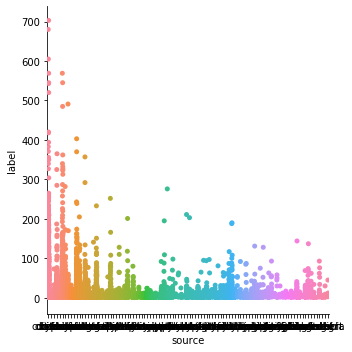

In [8]:
sns.catplot(x="source", y="label", data=x);